## 日内分时段的价量信息

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt

/home/aglv/aglv/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt

sys.path.append('/mnt/datadisk2/aglv/aglv/lab_aglv/forintern/')
from DataDaily import DataDaily

def factor_group(factor, group_number=10):
    '''按照因子值分组,grp1最小'''
    fg = factor.apply(
        lambda x: pd.qcut(x.rank(method='first'), q=group_number, labels=False) + 1, 
        axis=1)
        
    def _factor_group(factor_daily:pd.Series):
        dic = {f'group{str(g_value)}':factor_daily[factor_daily == g_value].index.tolist() for g_value in range(1, 1+group_number)}
        return pd.Series(dic)
    
    return {'group_stock':fg.apply(_factor_group, axis=1), 'group_index':fg}

def group_backtest(price:pd.DataFrame, factor:pd.DataFrame, group_number=10):
    '''
    分组回测,日度调仓,所有股票等权买入(买入各个股票的价值相同)  

    Paras:
    price:日频价格数据,index:Date,
    factor:日度因子值,index:Date,
    group_number:分组数,默认值为10, 组数大的因子值大

    Return:
    index:日期, col:组别, value: 指定日期下指定组数的收益率
    '''

    if 'Date' in factor.columns:
        factor = factor.set_index('Date')
    elif 'date' in factor.columns:
        factor = factor.set_index('date')

    factor = factor.shift(1).iloc[1:] # 第i日的因子作为第i+1日对应股票的调仓依据
    
    ret = price / price.shift(1)
    ret = ret.loc[factor.index, factor.columns].fillna(1)

    fg = factor_group(factor, group_number=group_number)['group_index']
    
    dic = {}
    for g_value in tqdm(range(1, 1+group_number)):
        is_in_group = fg.applymap(lambda x: 1 if x == g_value else 0)
        group_ret_daily = (ret * is_in_group).sum(axis=1) / is_in_group.sum(axis=1)
        dic[f'group{g_value}'] = group_ret_daily

    g_ret = pd.DataFrame(dic)
    # g_ret['g_mean'] = g_ret.mean(axis=1)
    g_ret['benchmark'] = ret.mean(axis=1)

    return g_ret

def position_backtest(price:pd.DataFrame, position:pd.DataFrame):
        '''
        有待完成
        用仓位数据来进行回测,
        price:日度价格数据
        position:对应的日度股票持仓数量
        '''
        holding = price * position
        holding_all = holding.sum(axis=1)
        ret = holding_all / holding_all - 1

        return ret

def group_backtest_plot(price:pd.DataFrame, factor:pd.DataFrame, group_number=5, save_path=None, is_zz1000=False, gap=1):
    '''
    分组回测
    Para:
    price:日频价格数据,index:Date,
    factor:日度因子值,index:Date,
    group_number:分组数,默认值为10, 组数大的因子值大
    '''

    if gap == 1:
        g_ret = group_backtest(price=price, factor=factor, group_number=group_number)
    else:
        g_ret = group_backtest_gapday(price=price, factor=factor, group_num=group_number, gap=gap) 

    g_ret.index = [str(i) for i in g_ret.index]
    g_ret_cumsum = g_ret.cumprod()

    if is_zz1000:
        index_data = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/index_data/close.csv')
        index_data.set_index('Unnamed: 0', inplace=True)
        zz1000 = index_data.loc[852, :]
        zz1000 = zz1000.loc[g_ret.index]
        zz1000_bt = zz1000 / zz1000.iloc[0]
        g_ret_cumsum['zz1000'] = zz1000_bt
    
    plt.style.use('seaborn')
    g_ret_cumsum.plot(figsize=(12, 6), linewidth=1)

    if is_zz1000:
        plt.plot(zz1000_bt, linewidth=2)

    plt.legend()

    if save_path is not None:
        plt.savefig(save_path, facecolor='white', dpi=300)
    plt.show()


def group_backtest_gapday(price:pd.DataFrame, factor:pd.DataFrame, group_num=5, gap=10):
    '''
    换仓期为gap日的回测系统
    '''

    def handle_factor(factor=factor, gap=gap):
        '''将因子值按gap日求平均得到新的间隔gap日的因子序列'''
        if 'Date' in factor.columns:
            factor.set_index('Date', inplace=True)
        elif 'date' in factor.columns:
            factor = factor.set_index('date')
        
        new_index = [factor.index[i] for i in range(0, len(factor.index), gap)]
        new_factor = pd.DataFrame(
            [factor.loc[new_index[i]:new_index[i+1]].mean() for i in range(len(new_index) - 1)], 
            index=new_index[:-1]
        )
        
        return new_factor, new_index
    
    new_factor, new_index = handle_factor(factor=factor)

    # 做axis=1的因子中性化 方便fillna(0)
    new_factor = ((new_factor.T - new_factor.T.mean()) / (new_factor.T.std() + 1e-10)).T.fillna(0)
    
    new_factor = new_factor.shift(1).iloc[1:] # shift意为 日期i作为日期i+1的分组指标
    
    ret = pd.DataFrame(
        [price.loc[new_index[i]] / (price.loc[new_index[i-1]] + 1e-10) for i in range(1, len(new_index))],
        index=new_index[1:]
    )
    ret = ret.loc[new_factor.index, new_factor.columns].fillna(1)

    fg = factor_group(new_factor, group_number=group_num)['group_index']
    
    dic = {}
    for g_value in tqdm(range(1, 1+group_num)):
        is_in_group = fg.applymap(lambda x: 1 if x == g_value else 0)
        group_ret_daily = (ret * is_in_group).sum(axis=1) / is_in_group.sum(axis=1)
        dic[f'group{g_value}'] = group_ret_daily

    g_ret = pd.DataFrame(dic)
    g_ret['benchmark'] = ret.mean(axis=1)

    return g_ret


def check_extrme_factor(factor:pd.DataFrame, date, rolling_day=10, is_large=True, check_num=10, check_period=5):
    '''
    检测某天的极端因子值的股票表现
    因子值按照向前rolling 10天的平均值进行排序 绘图显示前后5天的股票表现, 在jupyter中检测
    需要用到datadaily类获取日频价格数据
    '''

    if 'date' in factor.columns:
        factor = factor.set_index('date')
    elif 'Date' in factor.columns:
        factor = factor.set_index('Date')

    if date not in factor.index:
        raise ValueError('日期为非交易日')

    factor = factor.rolling(10).mean()
    factor_date = factor.loc[date]
    factor_date_sorted = factor_date.sort_values().dropna()

    if is_large:
        check_stock = factor_date_sorted.iloc[-check_num:].index
    else:
        check_stock = factor_date_sorted.iloc[:check_num].index
    
    close = datadaily.adjclose
    for stock in check_stock:
        date_id = close.index.get_loc(date)
        p_date = close.iloc[date_id-check_period:date_id+check_period+1, :].loc[:, stock]
        p_date.index = [str(i) for i in p_date.index]

        plt.plot(p_date)
        plt.title(stock)
        plt.show()


def factors_corr(factor_folder):
    '''检测因子之间相关性'''
    import glob, os
    import seaborn as sns

    csv_path = glob.glob(os.path.join(factor_folder, '*.csv'))
    new_path = []
    for p in csv_path:
        f_name = p.split('/')[-1][:-4]
        if 'relu' in f_name:
            new_path.append(p)
    
    new_path = new_path[:8]

    dfs = [pd.read_csv(f).set_index('date') for f in new_path]

    num = len(dfs)
    print(num)

    corrs = pd.DataFrame(index=range(num), columns=range(num))
    for i in range(num):
        print(i, new_path[i].split('/')[-1][:-4])
        for j in range(num):
            if j < i:
                corrs.iloc[i, j] = corrs.iloc[j ,i]
            elif j == i:
                corrs.iloc[i, j] = 1
            else:
                corrs.iloc[i, j] = dfs[i].corrwith(dfs[j]).mean()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(corrs.astype(float), annot=True, cmap='Greens', fmt=".2f")
    plt.title('Correlation with Means Heatmap')
    plt.show()

In [4]:
clo = pd.read_hdf('/mnt/datadisk2/aglv/aglv/lab_aglv/close_21_23.h5')
clo

SH600000  SH600004  SH600006  SH600007  SH600008  SH600009  \
Date     EndTime                                                               
20210104 09:31        9.64     14.01      8.82     12.35      2.86     76.46   
         09:32        9.60     13.97      8.84     12.36      2.84     76.17   
         09:33        9.60     14.00      8.83     12.37      2.85     76.10   
         09:34        9.58     13.90      8.83     12.33      2.85     75.74   
         09:35        9.58     13.88      8.94     12.28      2.85     75.36   
...                    ...       ...       ...       ...       ...       ...   
20231012 14:56        7.13     10.87      5.78     19.02      2.81     37.33   
         14:57        7.13     10.87      5.79     19.04      2.82     37.33   
         14:58        7.13     10.87      5.79     19.04      2.82     37.33   
         14:59        7.13     10.87      5.79     19.04      2.82     37.33   
         15:00        7.14     10.88      5.79     18.98      2.81     37.33   

                  SH600010  SH600011  SH600012  SH600015  ...  SZ301519  \
Date     EndTime                                          ...             
20210104 09:31        1.18      4.49      6.12      6.22  ...       NaN   
         09:32        1.17      4.47      6.16      6.20  ...       NaN   
         09:33        1.17      4.47      6.17      6.21  ...       NaN   
         09:34        1.17      4.46      6.16      6.21  ...       NaN   
         09:35        1.17      4.47      6.16      6.19  ...       NaN   
...                    ...       ...       ...       ...  ...       ...   
20231012 14:56        1.73      7.81     10.83      5.72  ...     23.05   
         14:57        1.73      7.82     10.82      5.73  ...     23.06   
         14:58        1.73      7.82     10.81      5.73  ...     23.06   
         14:59        1.73      7.82     10.81      5.73  ...     23.06   
         15:00        1.72      7.81     10.83      5.71  ...     23.05   

                  SZ301520  SZ301525  SZ301528  SZ301529  SZ301533  SZ301548  \
Date     EndTime                                                               
20210104 09:31         NaN       NaN       NaN       NaN       NaN       NaN   
         09:32         NaN       NaN       NaN       NaN       NaN       NaN   
         09:33         NaN       NaN       NaN       NaN       NaN       NaN   
         09:34         NaN       NaN       NaN       NaN       NaN       NaN   
         09:35         NaN       NaN       NaN       NaN       NaN       NaN   
...                    ...       ...       ...       ...       ...       ...   
20231012 14:56       65.80    101.99     84.05     44.24     41.43     61.38   
         14:57       65.65    101.81     84.08     44.28     41.39     61.37   
         14:58       65.64    101.81     84.10     44.28     41.39     61.34   
         14:59       65.64    101.81     84.10     44.28     41.39     61.34   
         15:00       65.64    101.90     84.29     44.35     41.40     61.33   

                  SZ301550  SZ301558  SZ301559  
Date     EndTime                                
20210104 09:31         NaN       NaN       NaN  
         09:32         NaN       NaN       NaN  
         09:33         NaN       NaN       NaN  
         09:34         NaN       NaN       NaN  
         09:35         NaN       NaN       NaN  
...                    ...       ...       ...  
20231012 14:56       50.40     14.08     22.72  
         14:57       50.21     14.01     22.69  
         14:58       50.18     14.00     22.69  
         14:59       50.18     14.00     22.69  
         15:00       50.30     14.01     22.69  

[161118 rows x 5175 columns]

In [5]:
def inverse(p:pd.DataFrame, l_min=30):
    l_ret = clo.groupby('Date', axis=0).apply(lambda x: x.iloc[l_min, :] / x.iloc[1, :] - 1) # 有些股票第0index伤没有数据
    r_ret = clo.groupby('Date', axis=0).apply(lambda x: x.iloc[-1, :] / x.iloc[l_min, :] -1)

    sym = l_ret - r_ret
    # sym = l_ret

    num = sym.shape[1] - sym.isna().sum(axis=1)
    inv_per = sym.sum(axis=1) / num
    
    return inv_per, sym, num

In [35]:
inv_per_30, sym_30, len_30 = inverse(clo, 30)

In [36]:
sym_30 = sym_30.replace(np.inf, np.nan)
sym_30

,SH600000,SH600004,SH600006,SH600007,SH600008,SH600009,SH600010,SH600011,SH600012,SH600015,...,SZ301519,SZ301520,SZ301525,SZ301528,SZ301529,SZ301533,SZ301548,SZ301550,SZ301558,SZ301559
Date,,,,,,,,,,,,,,,,,,,,,
20210104,-0.011469,0.019241,0.062834,-0.012984,0.007042,0.017330,-0.008547,0.002247,-0.009698,-0.004844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210105,-0.020851,-0.022525,-0.090946,-0.018562,-0.007005,-0.008205,0.000000,-0.011236,0.004970,-0.016205,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210106,-0.006156,0.037035,-0.017757,-0.023320,-0.003509,0.030233,0.008547,-0.025240,0.009764,-0.003200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210107,-0.020259,0.026377,-0.007157,-0.013481,0.007092,0.008737,0.042669,-0.004566,0.001745,-0.011144,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210108,-0.001012,0.004077,-0.010992,-0.003238,-0.017680,0.013376,-0.017168,0.004576,0.016472,0.006390,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20230928,0.005596,-0.016076,0.010909,0.006670,0.003534,-0.016480,0.000000,-0.005036,-0.013572,-0.005217,...,0.009081,0.024356,0.037189,0.009454,0.013269,0.022912,0.034619,0.033306,0.005301,NaN
20231009,-0.007114,-0.001671,0.000003,0.008799,0.007042,-0.006651,-0.005780,0.006371,-0.018227,-0.003533,...,0.006312,-0.014489,0.001142,0.009471,-0.001399,0.000724,0.009932,-0.028857,0.007413,NaN
20231010,0.000032,0.001843,-0.003509,-0.009901,0.000013,0.010713,-0.005680,-0.008785,0.001900,-0.006990,...,0.018988,0.011108,-0.017733,0.022202,0.039483,0.015364,0.014586,0.081557,0.137839,NaN


In [45]:
def cVaR_series(series, c_level=0.9):
    right_VaR = series.quantile(c_level)
    # left_VaR = series.quantile(1- c_level)

    # X_low = pd.Series(series[series < left_VaR])
    X_high = pd.Series(series[series > right_VaR])

    # low_mean = X_low.mean() if len(X_low) > 0 else 0
    high_mean = X_high.mean() if len(X_high) > 0 else 0

    return high_mean

In [46]:
cvar_ret_v1 = sym_30.rolling(30).progress_apply(cVaR_series)
cvar_ret_v1

2938818it [30:19, 1615.06it/s]


,SH600000,SH600004,SH600006,SH600007,SH600008,SH600009,SH600010,SH600011,SH600012,SH600015,...,SZ301519,SZ301520,SZ301525,SZ301528,SZ301529,SZ301533,SZ301548,SZ301550,SZ301558,SZ301559
Date,,,,,,,,,,,,,,,,,,,,,
20210104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20230928,0.012251,0.022253,0.019023,0.019826,0.023691,0.030921,0.019052,0.024864,0.017091,0.011867,...,0.045687,NaN,NaN,NaN,NaN,0.108283,NaN,NaN,NaN,NaN
20231009,0.008958,0.021525,0.018549,0.019826,0.023691,0.024644,0.019052,0.024864,0.016973,0.011867,...,0.045687,NaN,NaN,NaN,NaN,0.108283,NaN,NaN,NaN,NaN
20231010,0.008958,0.021525,0.016847,0.019826,0.023691,0.024644,0.019052,0.024864,0.016973,0.011867,...,0.045687,NaN,NaN,NaN,NaN,0.108283,NaN,NaN,NaN,NaN


In [47]:
cvar_ret_v1.to_csv('/mnt/datadisk2/aglv/aglv/aglv_factor/Oct_factor/cvar_l-r_ret_r30.csv')

In [43]:
sym_30_stack = sym_30.stack()
sym_30_stack

Date              
20210104  SH600000   -0.011469
          SH600004    0.019241
          SH600006    0.062834
          SH600007   -0.012984
          SH600008    0.007042
                        ...   
20231012  SZ301533   -0.025704
          SZ301548   -0.024066
          SZ301550    0.045943
          SZ301558   -0.031305
          SZ301559    0.011366
Length: 3130989, dtype: float64

In [6]:
da23 = pd.read_hdf('/mnt/datadisk2/aglv/aglv/lab_aglv/data2023.h5')
da23

Open  Close   High    Low  LastVolume  \
Date     InstrumentID EndTime                                           
20230103 SZ000001     09:31    13.20  13.16  13.23  13.06   3725537.0   
                      09:32    13.16  13.14  13.18  13.11   1122500.0   
                      09:33    13.14  13.17  13.17  13.11   1284694.0   
                      09:34    13.17  13.20  13.20  13.16   1218457.0   
                      09:35    13.20  13.19  13.19  13.16   1066087.0   
...                              ...    ...    ...    ...         ...   
20231012 SH689009     14:56    33.94  33.88  33.94  33.88     23275.0   
                      14:57    33.92  33.89  33.92  33.86      9297.0   
                      14:58    33.89  33.89  33.89  33.89         0.0   
                      14:59    33.89  33.89  33.89  33.89         0.0   
                      15:00    33.77  33.77  33.77  33.77     62011.0   

                               LastTurnOver  
Date     InstrumentID EndTime                
20230103 SZ000001     09:31    4.894731e+07  
                      09:32    1.473833e+07  
                      09:33    1.688369e+07  
                      09:34    1.605823e+07  
                      09:35    1.404670e+07  
...                                     ...  
20231012 SH689009     14:56    7.893110e+05  
                      14:57    3.150930e+05  
                      14:58    0.000000e+00  
                      14:59    0.000000e+00  
                      15:00    2.094111e+06  

[222608001 rows x 6 columns]

<ipython-input-39-a26e86dfb8fd>:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  vol_unique = pd.Series(index=p_unique)


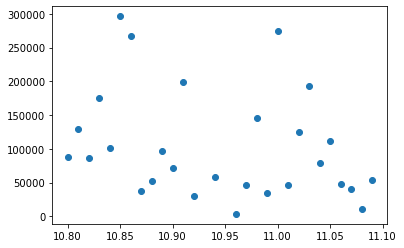

In [40]:
def draw_price_vol_unique(data:pd.DataFrame):
    '''
    data:MultiIndex对象, 一列价格一列成交量数据
    '''
    p_unique = data['Close'].unique()
    vol_unique = pd.Series(index=p_unique)
    for p in vol_unique.index:
        vol_unique.loc[p] = data['LastVolume'][data['Close'] == p].sum()

    plt.scatter(p_unique, vol_unique)
    

draw_price_vol(eg0103)

In [37]:
eg0103 = da23.xs('20230111', level='Date')
eg0103 = eg0103.xs('SZ000023', level='InstrumentID')
eg0103 = eg0103.iloc[:, [1, 4]]
# eg0103['Close'] = (eg0103['Close'] - eg0103['Close'].mean()) / (eg0103['Close'].std())
# eg0103['LastVolume'] = (eg0103['LastVolume'] - eg0103['LastVolume'].mean()) / eg0103['LastVolume'].std()
# plt.scatter(eg0103.iloc[:, 0], eg0103.iloc[:, 1])
eg0103.iloc[:, 0].unique()

array([11.05, 11.07, 11.03, 11.02, 11.01, 11.  , 11.04, 11.06, 11.09,
       11.08, 10.98, 10.99, 10.97, 10.96, 10.94, 10.92, 10.91, 10.89,
       10.9 , 10.88, 10.87, 10.86, 10.85, 10.84, 10.83, 10.82, 10.81,
       10.8 ])

In [41]:
def draw_price_vol_unique(data:pd.DataFrame):
    '''
    data:MultiIndex对象, 一列价格一列成交量数据
    '''
    p_unique = data['Close'].unique()
    vol_unique = pd.Series(index=p_unique)
    for p in vol_unique.index:
        vol_unique.loc[p] = data['LastVolume'][data['Close'] == p].sum()

    plt.scatter(p_unique, vol_unique)

In [48]:
def draw_price_vol(data:pd.DataFrame):
    '''
    data:MultiIndex对象, 一列价格一列成交量数据
    '''
    # p_unique = data['Close'].unique()
    # vol_unique = pd.Series(index=p_unique)
    # for p in vol_unique.index:
    #     vol_unique.loc[p] = data['LastVolume'][data['Close'] == p].sum()

    plt.scatter(data.iloc[:, 0], data.iloc[:, 1])

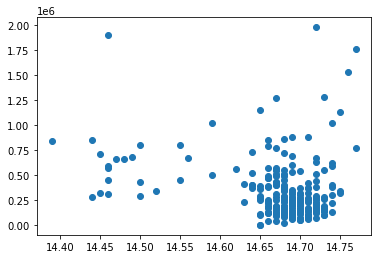

In [49]:
draw_price_vol(da23.xs('20230111', level='Date').xs('SZ000001', level='InstrumentID').iloc[:, [1, 4]])

<ipython-input-41-8dfb54197967>:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  vol_unique = pd.Series(index=p_unique)


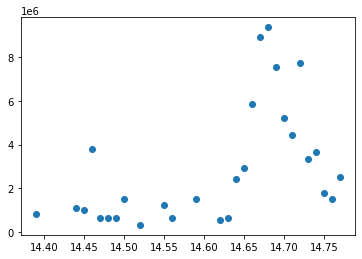

In [46]:
draw_price_vol_unique(da23.xs('20230111', level='Date').xs('SZ000001', level='InstrumentID').iloc[:, [1, 4]])

In [12]:
# eg0103 = eg0103.iloc[:, [1, 4]]
eg0103['Close'] = (eg0103['Close'] - eg0103['Close'].mean()) / (eg0103['Close'].std())
eg0103['LastVolume'] = (eg0103['LastVolume'] - eg0103['LastVolume'].mean()) / (eg0103['LastVolume'].std())
eg0103

<ipython-input-12-488c6194899d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eg0103['Close'] = (eg0103['Close'] - eg0103['Close'].mean()) / (eg0103['Close'].std())
<ipython-input-12-488c6194899d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eg0103['LastVolume'] = (eg0103['LastVolume'] - eg0103['LastVolume'].mean()) / (eg0103['LastVolume'].std())


,Close,LastVolume
EndTime,,
09:31,-2.177911,3.488321
09:32,-2.284956,0.275326
09:33,-2.124389,0.475526
09:34,-1.963822,0.393768
09:35,-2.017345,0.205694
...,...,...
14:56,1.086949,0.210919
14:57,1.086949,-0.233957
14:58,1.086949,-1.110204


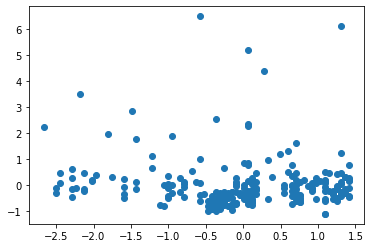

In [14]:
plt.scatter(eg0103.iloc[:, 0], eg0103.iloc[:, 1])

In [7]:
cd /mnt/datadisk2/aglv/aglv/lab_aglv/forintern/

/mnt/datadisk2/aglv/aglv/lab_aglv/forintern


In [8]:
datadaily = DataDaily()
clo_day = datadaily.adjclose

load ./data_daily.h5...


In [13]:
clo_day.index = [str(i) for i in clo_day.index]

100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


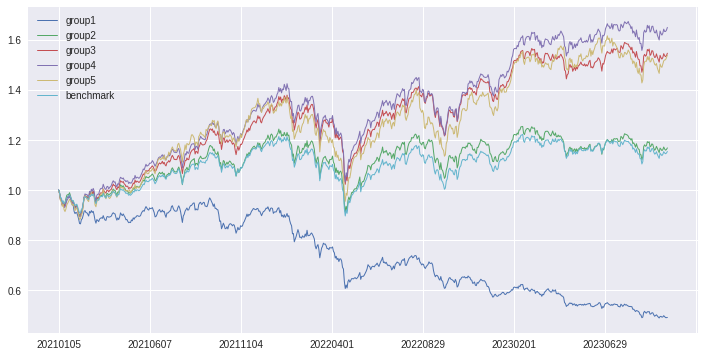

In [37]:
group_backtest_plot(clo_day, sym_30, gap=1)

In [31]:
sym_30.to_csv('/mnt/datadisk2/aglv/aglv/aglv_factor/Oct_factor/min30_reverse_multi.csv')

In [7]:
inv_per_30[inv_per_30 > 0.3]

Date
20210107    0.491215
20210111    0.320453
20210129    0.375773
20210219    0.552888
20210310    0.422368
20210416    0.317719
20210924    0.356791
20210927    0.516331
20211027    0.350175
20211206    0.319962
20211224    0.369097
20220120    0.502164
20220125    0.600356
20220127    0.520623
20220208    0.339150
20220308    0.627451
20220309    0.378816
20220315    0.665788
20220318    0.332567
20220426    0.592132
20220510    0.435093
20220524    0.435498
20220609    0.422764
20220610    0.406558
20220629    0.388727
20220705    0.300846
20220712    0.310615
20220802    0.528848
20220824    0.506831
20220829    0.324503
20220831    0.541223
20220915    0.515165
20220923    0.331471
20220926    0.366645
20220928    0.335539
20220930    0.301543
20221028    0.554135
20221111    0.341587
20221115    0.379590
20221219    0.563690
20221222    0.418221
20221226    0.301883
20230209    0.406052
20230321    0.323805
20230425    0.454194
20230428    0.368739
20230606    0.386799
20230627

3429.6

In [32]:
sym_30[inv_per_30 > 0.1]

,SH600000,SH600004,SH600006,SH600007,SH600008,SH600009,SH600010,SH600011,SH600012,SH600015,...,SZ301519,SZ301520,SZ301525,SZ301528,SZ301529,SZ301533,SZ301548,SZ301550,SZ301558,SZ301559
Date,,,,,,,,,,,,,,,,,,,,,
20210106,1.0,-1.0,1.0,-1.0,NaN,-1.0,NaN,-1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210107,-1.0,1.0,1.0,1.0,NaN,1.0,-1.0,NaN,1.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210111,-1.0,1.0,-1.0,-1.0,NaN,1.0,-1.0,1.0,1.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210113,1.0,1.0,1.0,-1.0,-1.0,1.0,NaN,-1.0,NaN,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210122,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20230918,NaN,-1.0,1.0,-1.0,NaN,-1.0,NaN,1.0,1.0,1.0,...,NaN,NaN,-1.0,-1.0,-1.0,1.0,NaN,-1.0,NaN,NaN
20230919,-1.0,-1.0,-1.0,1.0,NaN,-1.0,-1.0,-1.0,NaN,1.0,...,1.0,NaN,1.0,-1.0,-1.0,1.0,NaN,-1.0,NaN,NaN
20230922,NaN,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,NaN,-1.0,...,-1.0,NaN,1.0,1.0,1.0,1.0,-1.0,1.0,NaN,NaN


In [8]:
eg = clo.xs('20210107', level='Date')
eg2 = eg.iloc[-1, :] / eg.iloc[0, :] - 1
eg2.mean()

-0.021180365723860194

In [9]:
index_close = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/data_index/close.csv')
hs300_clo = index_close.iloc[2, 1:]
hs300_clo.index = [str(i) for i in hs300_clo.index]
hs300_clo.index.names = ['date']
hs300_clo = hs300_clo.loc['20210101':]
hs300_clo

date
20210104    5267.7181
20210105    5368.5049
20210106    5417.6677
20210107    5513.6568
20210108    5495.4306
              ...    
20231107    3619.7593
20231108    3611.0723
20231109    3612.8263
20231110    3586.4893
20231113    3579.4141
Name: 2, Length: 693, dtype: float64

In [12]:
index_op = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/data_index/open.csv')
hs300_op = index_op.iloc[2, 1:]
hs300_op.index = [str(i) for i in hs300_op.index]
hs300_op.index.names = ['date']
hs300_op = hs300_op.loc['20210101':]
hs300_op

date
20210104    5212.9313
20210105    5245.8355
20210106    5386.5144
20210107    5428.3944
20210108    5526.2876
              ...    
20231107    3623.7849
20231108    3610.6434
20231109    3603.1082
20231110    3596.0688
20231113    3593.9109
Name: 2, Length: 693, dtype: float64

In [27]:
# for date in inv_per_30[inv_per_30 > 0.4].index:
#     # 创建新的图形和坐标轴
#     fig, ax = plt.subplots(figsize=(10, 5))
    
#     date_id = hs300_clo.index.get_loc(date)
#     dates = hs300_clo.index[date_id-2:date_id+3]  # 取前后两天

#     # 确保绘制的数据与dates匹配
#     for i in range(len(dates)):
#         op = hs300_op[dates[i]]
#         cl = hs300_clo[dates[i]]

#         if cl >= op:
#             color = 'red'
#             ax.plot([dates[i], dates[i]], [op, cl], color=color, linewidth=4)
#         else:
#             color = 'green'
#             ax.plot([dates[i], dates[i]], [cl, op], color=color, linewidth=4)

#     # 设置X轴标签和标题
#     # ax.set_xticks(dates)
#     # ax.set_xticklabels(dates.date, rotation=45)
#     # ax.set_title(f'K线图示例 - {date.date()}')
#     # ax.set_ylabel('价格')

#     plt.tight_layout()
#     plt.show()
